In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [71]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
import sys
sys.path.extend(['../evaluation'])
from evaluate import model_preprocessed_filepath
import glob
from matplotlib import pyplot as plt
import math
%matplotlib inline

chencherry = SmoothingFunction().method2

In [3]:
def get_scores(filepath, subset='all-cat'):
    
    references_files = [f'../evaluation/references/dev/{subset}_reference{i}.lex' for i in range(3)]
    hypothesis_file = filepath

    scores = []
    hypothesis = []
    references = []

    with open(references_files[0], 'r', encoding='utf-8') as ref0,\
         open(references_files[1], 'r', encoding='utf-8') as ref1,\
         open(references_files[2], 'r', encoding='utf-8') as ref2,\
         open(hypothesis_file, 'r', encoding='utf-8') as hyp:


        for h, r0, r1, r2 in zip(hyp, ref0, ref1, ref2):

            references.append((r0[:-1], r1[:-1], r2[:-1]))
            hypothesis.append(h[:-1])

    for hyp, refs in zip(hypothesis, references):

        score = sentence_bleu([r.split() for r in refs], 
                              hyp.split(), 
                              smoothing_function=chencherry)

        scores.append(score)
        
    return scores, hypothesis, references
    

def plot_hist_bleu(filepath, ax, subset='all-cat'):

    scores, _, _ = get_scores(filepath, subset)
    
    s = pd.Series(scores)
    
    s.hist(ax=ax, bins=40)

In [14]:
def plot_all_models_hist_bleu(subset):
    
    models = sorted([os.path.basename(s) for s in glob.glob('../data/models/dev/*')])

    n_models = len(models)
    n_columns = 6
    n_rows = math.ceil(n_models / 6)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(30, 5*n_rows), sharey=True, sharex=True)

    for model, ax in zip(models, axes.ravel()):

        try:
            filepath = model_preprocessed_filepath(model, 'dev', subset)
        except FileNotFoundError as e:
            pass

        plot_hist_bleu(filepath, ax, subset)
        ax.set_title(model)

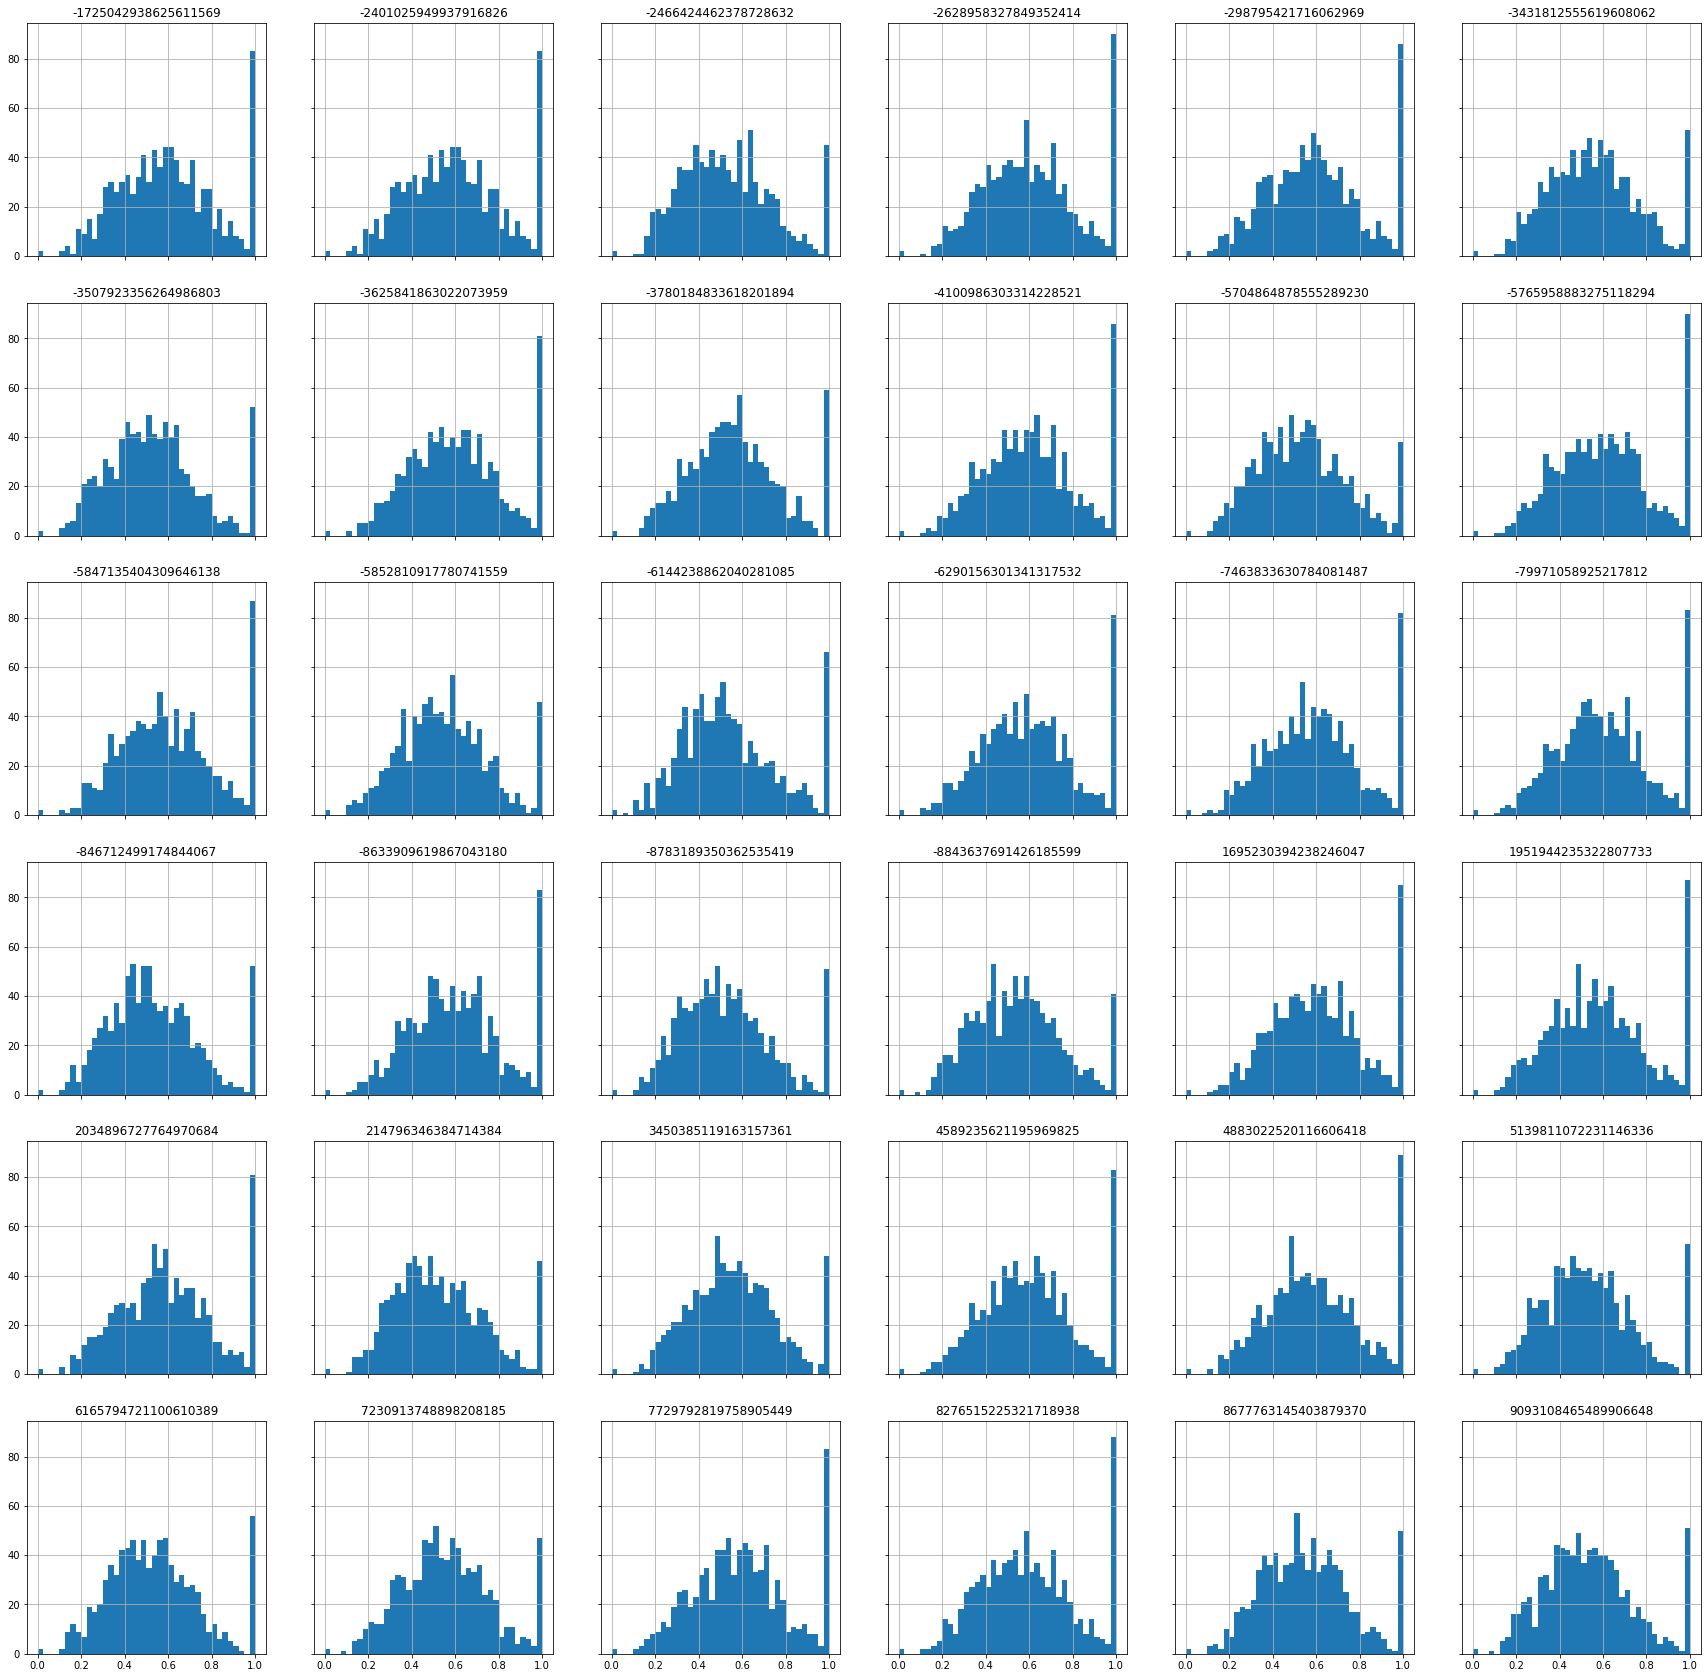

In [15]:
plot_all_models_hist_bleu('all-cat')

# Menores scores

In [12]:
models = [os.path.basename(s) for s in glob.glob('../data/models/dev/*')]

models_data = {}

for model in models:
    
    sentence_bleu_filepath = f'../data/models/dev/{model}/sentence_bleu.txt'
    try:
        model_texts_filepath = model_preprocessed_filepath(model, 'dev', 'all-cat')
    except FileNotFoundError:
        continue
    
    if os.path.isfile(sentence_bleu_filepath):
        with open(sentence_bleu_filepath, 'r', encoding='utf-8') as f:
            scores = [float(l[:-1]) for l in f.readlines()]
        with open(model_texts_filepath, 'r', encoding='utf-8') as f:
            hypothesis = [l[:-1] for l in f.readlines()]
    else:
        scores, hypothesis, _ = get_scores(model_texts_filepath, 'all-cat')

        with open(f'../data/models/dev/{model}/sentence_bleu.txt', 'w', encoding='utf-8') as f:
            for score in scores:
                f.write(f'{score}\n')
    
    models_data[model] = (scores, hypothesis)

In [74]:
#adicionar references
sys.path.append('../template_model')
from reading_thiagos_templates import load_dev, Entry

dev = load_dev()
def print_texts(ix):
    
    ix_data = []
    for model, (scores, hypothesis) in models_data.items():
        
        ix_data.append((model, scores[ix], hypothesis[ix]))
            
    print('{:^30}{:^10}{:^50}'.format('Model', 'Score', 'Hypothesis'))
    for l in dev[ix].lexes:
        print('{:^30}{:^10.3f}{:^50}'.format('reference', 1.0, l['text']))
    for model, score, hyp in sorted(ix_data, key=lambda d: d[1], reverse=True):
        
        print('{:^30}{:^10.3f}{:^50}'.format(model, score, hyp))

In [75]:
i = 0

def sai_cumeno():
    global i
    print_texts(i)
    i = i + 1

In [395]:
sai_cumeno()

            Model               Score                       Hypothesis                    
          reference             1.000   A popular dessert is Bionico and a variation of this dish can be honey.
          reference             1.000   Honey can be used as a variaton in Bionico which is a dessert.
          reference             1.000     Honey can be added to bionico, a dessert dish.  
     -3625841863022073959       0.735     honey can be added to bionico . is a dessert .  
     -7463833630784081487       0.735     honey can be added to bionico . is a dessert .  
     4589235621195969825        0.735     honey can be added to bionico . is a dessert .  
     7729792819758905449        0.735     honey can be added to bionico . is a dessert .  
     6165794721100610389        0.649     bionico is a dessert . honey can be added to .  
     9093108465489906648        0.637   honey can be used as a variation in bionico . is a dessert .
     -1725042938625611569       0.606   honey c